# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/Assignment1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Assignment1


In [ ]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Question 1
Real world datasets often have a mix of numeric and categorical features – this dataset is one such
example. To build models on such data, categorical features have to be encoded. Also, before
applying neural networks, it is a good practice to try simpler machine learning algorithms first.
For all models in Part B of the assignment, the following features should be used:
- Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality,
eigenvector_centrality, remaining_lease_years, floor_area_sqm
- Categorical features: month, flat_model_type, storey_range
One-hot encoding should be applied on categorical features.
Standardisation should be performed on numeric features.

a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using
entries from year 2020 and before as training data (with the remaining data from
year 2021 and 2022 used as test data).

Why is this done instead of using random train/test splits?

In [ ]:
# Split data

# year 2020 and before
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

answer:

This is done as it is a time series data set. We are attempting to predict the future housing prices. If we use a random train/test splits we would be training a model that predicts a price of a particular house in that region.

To be able to effectivly test if the model is able to predict real worl prices we have to test the model with new data, ie future prices. Which is not possible, hence we train the data set while holding back the price data for the most recent years to more accuratly test the models accuracy.

b) A team of data scientists has implemented a linear regression model via Scikit-
learn. They obtained a test R^2 value of 0.627 and happily shared with you that their
model only took a few seconds to train. They suggest you to try out an equivalent
deep learning model to see if you get a similar result. Recall that a linear regression
model is equivalent to a neural network with only 1 Dense layer (i.e. no hidden
layer) with linear activation and 1 output node.

However, modelling such a mix of feature types with neural networks requires some
changes to the input layer. Implement this neural network by following this tutorial
from the Keras documentation which guides you through the process of using the
Functional API to do so. After encoding / standardisation, the features should be
concatenated. Your architecture should resemble the figure shown in Appendix A.

In [ ]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")


all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
]

# Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate(
    [
      month_encoded,
      flat_model_type_encoded,
      storey_range_encoded,
      dist_to_nearest_stn_encoded,
      dist_to_dhoby_encoded,
      degree_centrality_encoded,
      eigenvector_centrality_encoded,
      remaining_lease_years_encoded,
      floor_area_sqm_encoded,
    ]
)




In [ ]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)


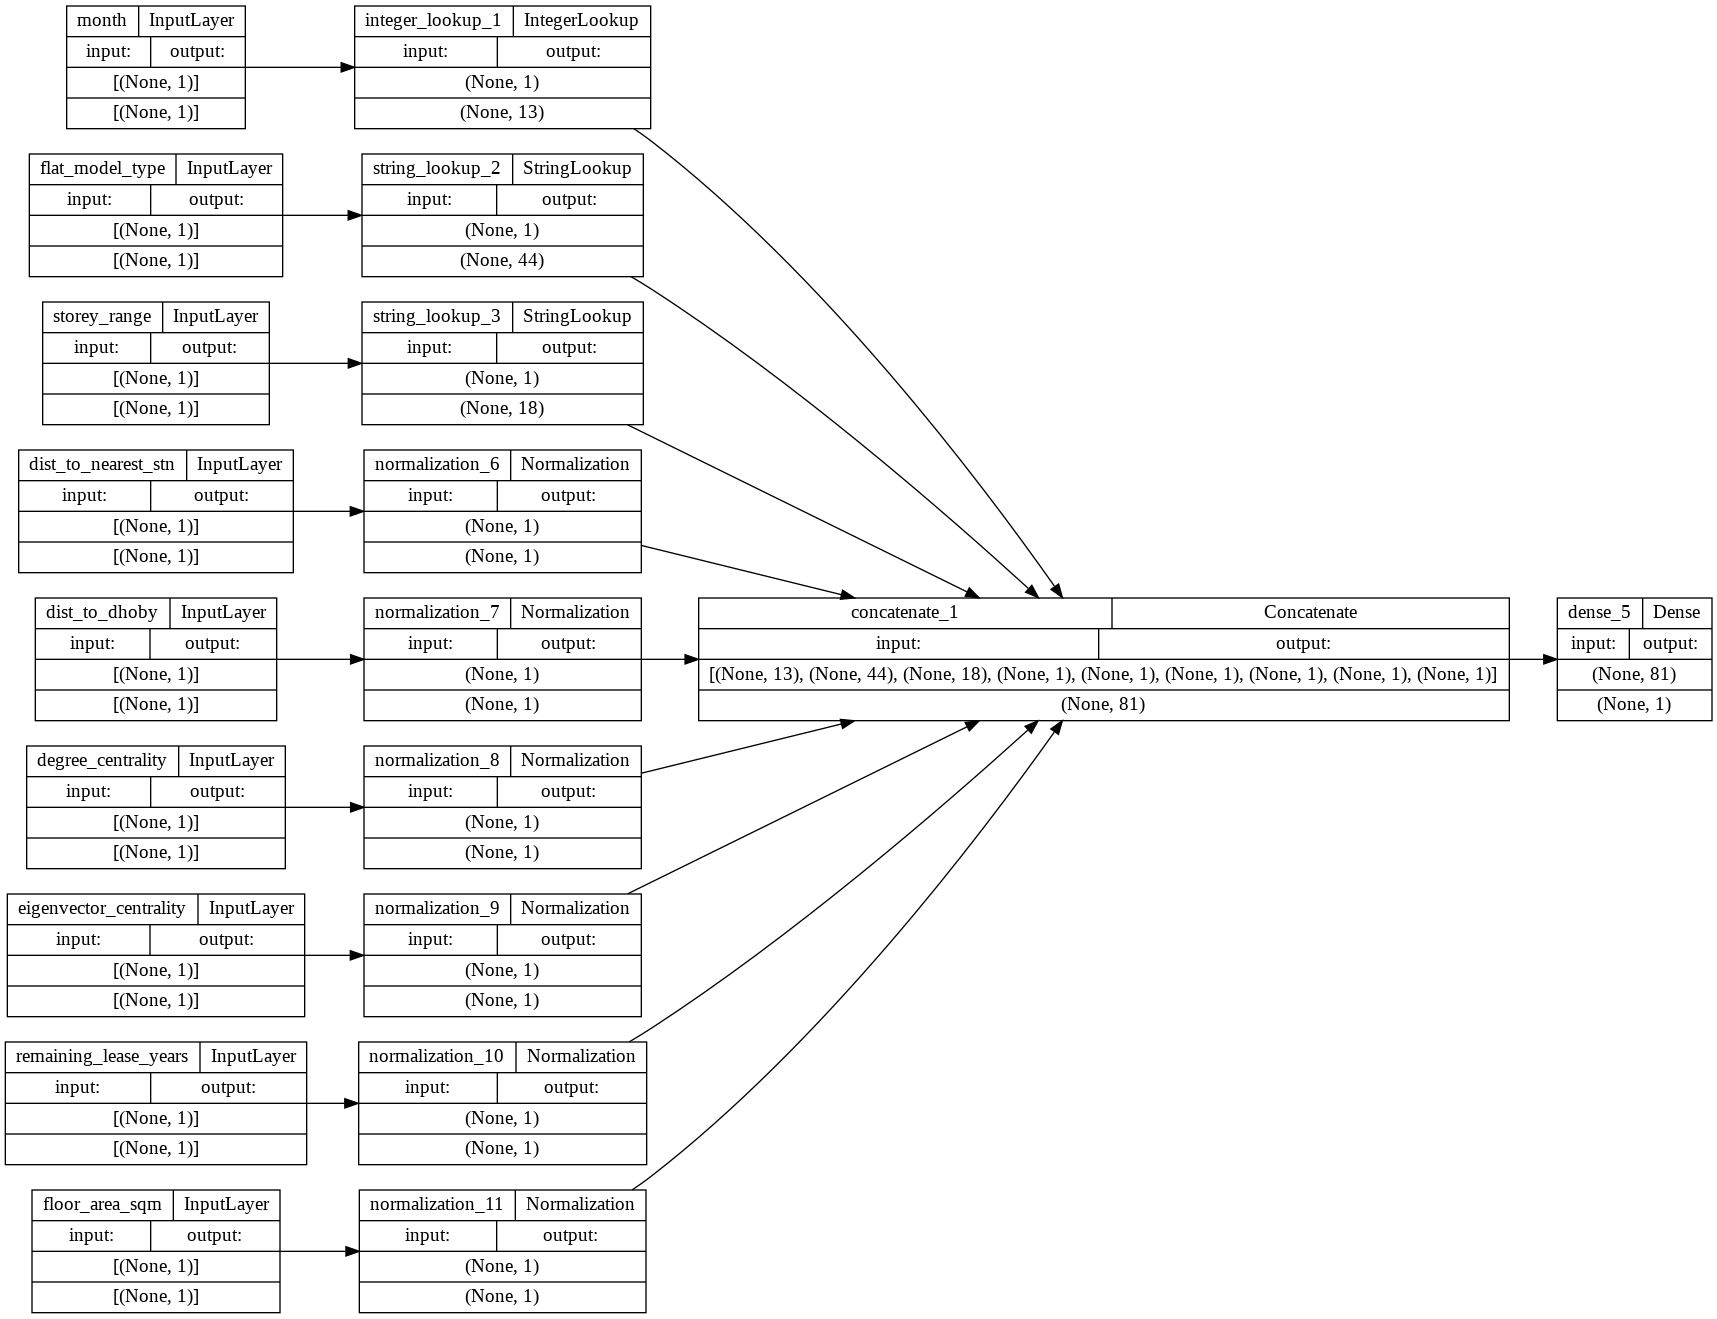

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


c) The team suggests you to train the model for 50 epochs using mini-batch gradient
descent with batch size = 256, Adam optimiser (with a default learning rate of α =
0.001) and mean square error as cost function. However, you find that your results
are far off from their model. Change the optimiser to SGD (with default learning rate
of α = 0.01) and observe how the problem gets fixed. Report the test R

2 value and
explain why the change to SGD fixes the problem faced when using Adam optimiser.
(Hint: Look carefully at how Adam is implemented and see how SGD is different.)

In [ ]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# running model with adam optimizer

output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r2])



H = model.fit(train_ds, 
              epochs=50,
              batch_size=256,
              validation_data=val_ds,
              verbose = 2)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 - 4s - loss: 219585773568.0000 - r2: -8.3474e+00 - val_loss: 301486505984.0000 - val_r2: -1.0083e+01 - 4s/epoch - 11ms/step
Epoch 2/50
342/342 - 3s - loss: 219584397312.0000 - r2: -8.3520e+00 - val_loss: 301484867584.0000 - val_r2: -1.0072e+01 - 3s/epoch - 9ms/step
Epoch 3/50
342/342 - 5s - loss: 219583070208.0000 - r2: -8.3501e+00 - val_loss: 301483294720.0000 - val_r2: -1.0103e+01 - 5s/epoch - 16ms/step
Epoch 4/50
342/342 - 3s - loss: 219581743104.0000 - r2: -8.3437e+00 - val_loss: 301481787392.0000 - val_r2: -1.0080e+01 - 3s/epoch - 8ms/step
Epoch 5/50
342/342 - 3s - loss: 219580481536.0000 - r2: -8.3458e+00 - val_loss: 301480181760.0000 - val_r2: -1.0121e+01 - 3s/epoch - 9ms/step
Epoch 6/50
342/342 - 3s - loss: 219579236352.0000 - r2: -8.3513e+00 - val_loss: 301478707200.0000 - val_r2: -1.0084e+01 - 3s/epoch - 10ms/step
Epoch 7/50
342/342 - 3s - loss: 219577827328.0000 - r2: -8.3379e+00 - val_loss: 301477003264.0000 - val_r2: -1.0079e+01 - 3s/epoch - 8ms/step
Epoch 8/50
342

In [ ]:
scores_adam = model.evaluate(val_ds, verbose =2)

print("scores of ADAM optimizer")
print(f"mse: {scores_adam[0]}")
print(f"r^2: {scores_adam[1]}")

180/180 - 1s - loss: 301409566720.0000 - r2: -1.0089e+01 - 1s/epoch - 7ms/step
scores of ADAM optimizer
mse: 301409566720.0
r^2: -10.08871841430664


In [ ]:
# wrong code but idk why

# y_pred = model.predict(val_ds)
# y_true = np.concatenate([y for x, y in val_ds], axis=0)
# y_pred.shape = y_true.shape
# metric = tfa.metrics.r_square.RSquare()
# metric.update_state(y_true, y_pred)
# result = metric.result()


In [ ]:
# running model with SGD optimizer

output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

opt = keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r2])


H = model.fit(train_ds, 
              epochs=50,
              batch_size=256,
              validation_data=val_ds,
              verbose = 2)

Epoch 1/50
342/342 - 4s - loss: 18728699904.0000 - r2: 0.1966 - val_loss: 13790000128.0000 - val_r2: 0.4959 - 4s/epoch - 11ms/step
Epoch 2/50
342/342 - 3s - loss: 5481927168.0000 - r2: 0.7678 - val_loss: 12796297216.0000 - val_r2: 0.5330 - 3s/epoch - 9ms/step
Epoch 3/50
342/342 - 3s - loss: 5026649088.0000 - r2: 0.7875 - val_loss: 12325087232.0000 - val_r2: 0.5493 - 3s/epoch - 9ms/step
Epoch 4/50
342/342 - 3s - loss: 4776963072.0000 - r2: 0.7976 - val_loss: 12102071296.0000 - val_r2: 0.5578 - 3s/epoch - 9ms/step
Epoch 5/50
342/342 - 5s - loss: 4609034240.0000 - r2: 0.8049 - val_loss: 11926616064.0000 - val_r2: 0.5641 - 5s/epoch - 14ms/step
Epoch 6/50
342/342 - 6s - loss: 4482668544.0000 - r2: 0.8106 - val_loss: 11662402560.0000 - val_r2: 0.5745 - 6s/epoch - 16ms/step
Epoch 7/50
342/342 - 4s - loss: 4384753664.0000 - r2: 0.8140 - val_loss: 11666561024.0000 - val_r2: 0.5739 - 4s/epoch - 12ms/step
Epoch 8/50
342/342 - 3s - loss: 4306892288.0000 - r2: 0.8173 - val_loss: 11521378304.0000 - 

In [ ]:
scores_sgd = model.evaluate(val_ds, verbose =2)

print("scores of SGD optimizer")
print(f"mse: {scores_sgd[0]}")
print(f"r^2: {scores_sgd[1]}")

180/180 - 1s - loss: 10645578752.0000 - r2: 0.6096 - 966ms/epoch - 5ms/step
scores of SGD optimizer
mse: 10645578752.0
r^2: 0.6095799803733826


In [ ]:
print("scores of ADAM optimizer")
print(f"mse: {scores_adam[0]}")
print(f"r^2: {scores_adam[1]}")
print()
print("scores of SGD optimizer")
print(f"mse: {scores_sgd[0]}")
print(f"r^2: {scores_sgd[1]}")

scores of ADAM optimizer
mse: 301409566720.0
r^2: -10.08871841430664

scores of SGD optimizer
mse: 10645578752.0
r^2: 0.6095799803733826


d) Add 1 hidden layer (10 units) to the architecture in Q1c and train it with the same
configuration as in Q1c (i.e. with Adam) except that the learning rate is increased to
0.08. Report the test R
2 value.

In [ ]:
x = layers.Dense(1, activation="linear")(all_features)
output = layers.Dense(10, activation="relu")(x)
model = keras.Model(all_inputs, output)

opt = keras.optimizers.Adam(learning_rate=0.08)
# opt = keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r2])


H = model.fit(train_ds, 
              epochs=50,
              batch_size=256,
              validation_data=val_ds,
              verbose = 2)

Epoch 1/50
342/342 - 4s - loss: 218024148992.0000 - r2: -9.1820e+01 - val_loss: 295626440704.0000 - val_r2: -1.0750e+02 - 4s/epoch - 11ms/step
Epoch 2/50
342/342 - 4s - loss: 208238985216.0000 - r2: -8.7648e+01 - val_loss: 278656253952.0000 - val_r2: -1.0128e+02 - 4s/epoch - 13ms/step
Epoch 3/50
342/342 - 6s - loss: 191039864832.0000 - r2: -8.0249e+01 - val_loss: 254814126080.0000 - val_r2: -9.2553e+01 - 6s/epoch - 16ms/step
Epoch 4/50
342/342 - 3s - loss: 170145906688.0000 - r2: -7.1391e+01 - val_loss: 227880566784.0000 - val_r2: -8.2643e+01 - 3s/epoch - 9ms/step
Epoch 5/50
342/342 - 3s - loss: 148342423552.0000 - r2: -6.2018e+01 - val_loss: 200456355840.0000 - val_r2: -7.2490e+01 - 3s/epoch - 9ms/step
Epoch 6/50
342/342 - 3s - loss: 127549186048.0000 - r2: -5.3232e+01 - val_loss: 174785757184.0000 - val_r2: -6.3159e+01 - 3s/epoch - 9ms/step
Epoch 7/50
342/342 - 3s - loss: 109625352192.0000 - r2: -4.5563e+01 - val_loss: 152756994048.0000 - val_r2: -5.5104e+01 - 3s/epoch - 9ms/step
Epo

In [ ]:
scores_1layer = model.evaluate(val_ds, verbose =2)

print("scores of 1 layer optimizer")
print(f"mse: {scores_1layer[0]}")
print(f"r^2: {scores_1layer[1]}")

180/180 - 1s - loss: 97769684992.0000 - r2: -3.4932e+01 - 983ms/epoch - 5ms/step
scores of 1 layer optimizer
mse: 97769684992.0
r^2: -34.932350158691406


e) Compare the performance of the linear regression model to the Dense layer (Q1c)  and the NN architecture (Q1d) and suggest reasons for the observations you made.

##Question 2 

Neural networks offer much more than fundamental machine learning algorithms. In this part of  the assignment, we will investigate one of its advantages: the use of trainable embeddings. Also,  we will learn how to set up a quick and convenient way of tuning your neural network models.  
Instead of using one-hot encoding, an alternative approach is to use embeddings to encode  categorical variables. Such an approach utilises the ability of neural networks to learn richer  representations1 of the data – an edge it has over traditional ML models.

a) Further split the data from year 2020 and before (i.e. those not in test set) by  using data from year 2020 as validation set and the rest as the training set.

In [ ]:
# year 2020 and before
train_dataframe = df[df['year'] < 2020]
val_dataframe = df[df['year'] == 2020]
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)


train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

b) For each categorical variable, replace the one-hot encoding with the layer  tf.keras.layers.Embedding(). Set output_dim = floor(num_categories//divisor).  ‘num_categories’ refers to the number of categories in the categorical variable.  ‘divisor’ is a parameter which we will tune later (Hint: You will still need the  lookup classes from Q1b. Read the documentation to find out what to change.) 

The Embedding layer produces a 2D output (3D, including batch), which cannot  be concatenated with the other features. Add a Flatten layer to resolve this. 

In [ ]:
import math

def embed_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    divisor = 2

    num_categories = lookup.vocabulary_size()
    embedded_feature = tf.keras.layers.Embedding(input_dim = num_categories, output_dim = math.floor(num_categories//divisor) )

    embedded_feature = embedded_feature(feature)
    embedded_feature = layers.Flatten()(embedded_feature)

    return embedded_feature

flat_model_type_embed = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")


# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")


all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
]

# Integer categorical features
month_embed = embed_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_embed = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_embed = embed_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate([month_embed,
                                  flat_model_type_embed,
                                  storey_range_embed,
                                  dist_to_nearest_stn_encoded,
                                  dist_to_dhoby_encoded,
                                  degree_centrality_encoded,
                                  eigenvector_centrality_encoded,
                                  remaining_lease_years_encoded,
                                  floor_area_sqm_encoded,]
                                  )




In [ ]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

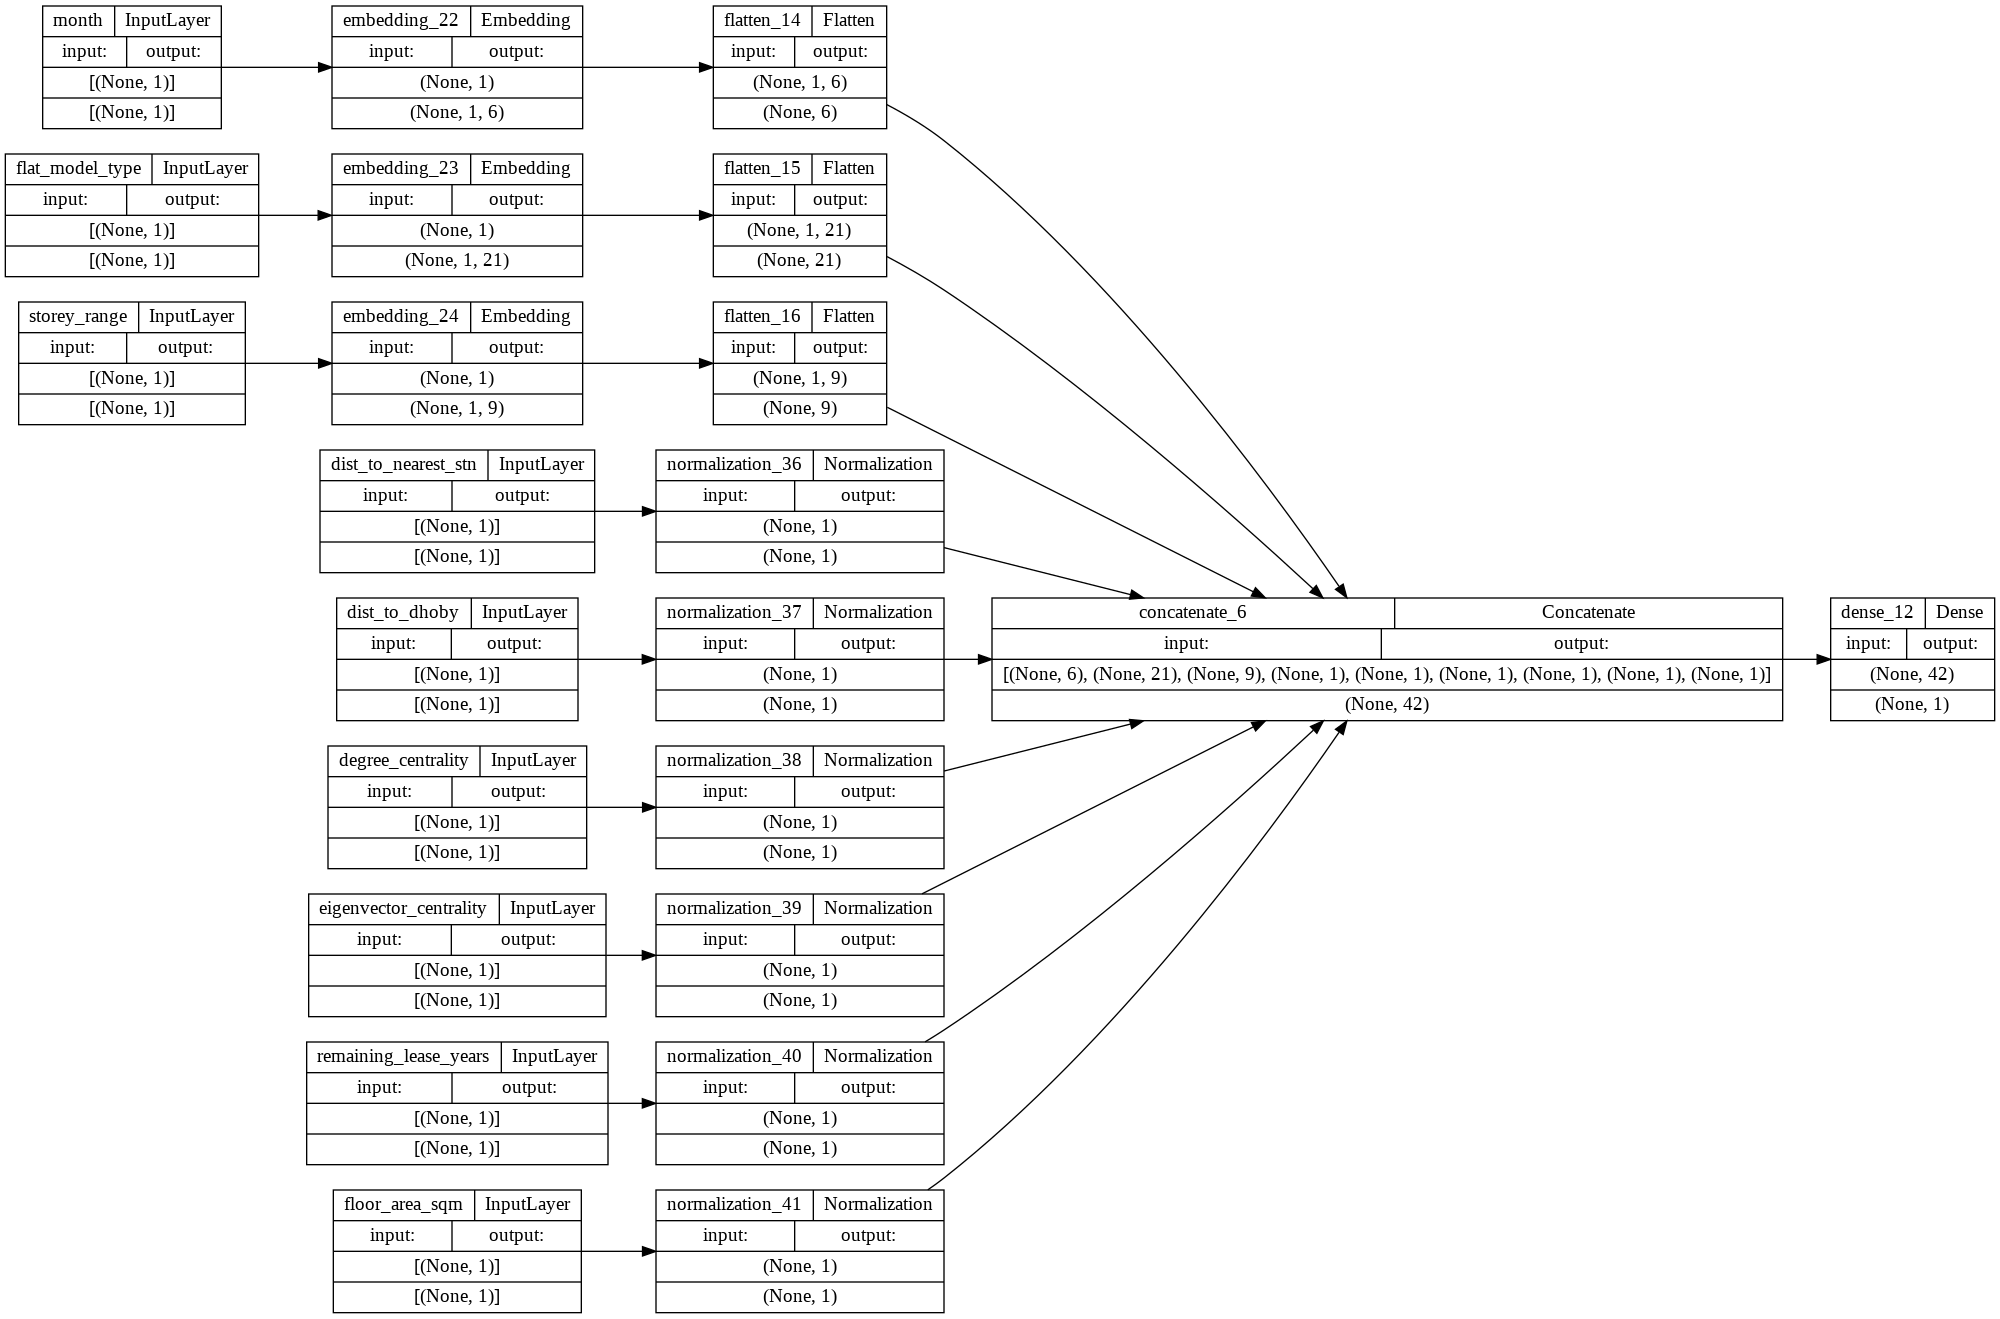

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

c) Via a callback, introduce early stopping (based on val_loss, with patience of  10 epochs) to the model. 
Using this as a reference, use KerasTuner (with the RandomSearch algorithm)  to tune the model on the validation set, according to the following ranges: - Number of neurons: min=4, max=32, step=4 
- Learning rate: min=1e-4, max=2e-1, sampling=’log’ 
- Divisor: min=1, max=2, step=1 
Run 10 iterations of parameter search (i.e. max_trials=10), each for 50 epochs  and report the best set of hyperparameters (based on validation accuracy). 



d) Using the best model configuration, train a model on the non-test split (i.e.  year 2020 and before) for 50 epochs. Generate a plot to show how the train  and test root mean square errors (RMSE) changes across epochs.  (Tip: You can skip the first few epochs if the plot gets dominated by them) 

e) Using the model from the best epoch, report the test R2 value and show the  top 30 test samples with the largest errors. List down any trends you find in  these samples and suggest ways to reduce these errors.  
(Tip: Add the prediction error as a column in the DataFrame and sort by it.)


##Question 3 

Model degradation is a common issue faced when deploying neural network models in the real  world. In typical coursework settings, you learn the ropes by experimenting on toy datasets, which  only offers a static snapshot of the situation. Real life problems, such as the analysis of factors  influencing HDB prices, have new data points coming in daily that might exhibit a different pattern  from older data points due to factors such as changes in government policy or market sentiments.  In such situations, models trained on older data points that differ greatly from the new data could  perform poorly. In the last part of this assignment, we will investigate whether this has happened. 
There are 2 datasets to work with: ‘HDB_price_prediction.csv’ and ‘HDB_price_prediction_old.csv’.  The latter is a subset of the former: both start from the same date but the latter ends on August  2021 while the former has data until August 2022. Both have the same set of training data (2020  and before) but the test data for the latter (i.e. ‘old test set’) is up till August 2021, while the test  set from the former has complete data from 2021, along with data till August 2022 (‘new test set’).


a) Apply your model from Q2d on the ‘old test set’. On the ‘new test set’, split  it into 2021 and 2022. For all 3 test sets, report the test R2 value you obtained. 

b) The team that produced the linear regression model shared with you their  results (test R2 values): 0.76 on the old test set, 0.715 when only using 2021  data as test set and 0.464 when only using 2022 data as test set. 
In light of this (along with their result in Q1b and your results from Q3a),  compare the extent to which model degradation has impacted your model to  that of the team’s linear regression model and explain why this has occurred.


c) Model degradation could be caused by various data distribution shifts2:  covariate shift (features), label shift and/or concept drift (altered relationship  between features and labels). Recall that machine learning models generally  need the test data distribution to be similar to the training data distribution.  
With appropriate plots, visualise the distributions of all the features and labels  used by the model. Which variable(s) showed the largest covariate/label shift that might have led to the drop in model performance as seen in Q3b? With  these insights, suggest a way to address the problem of model degradation. (Note: Only include plots relevant to your answer. Do not include all plots.)

d) The team passed you a script (‘RFE.py’) that recursively removes features  from a neural network, so as to find the best feature subset. Run this piece of  code with your model from Q2d and report the best feature subset obtained. 

e) RFE on the ‘old test set’ eliminated features degree_centrality and month. It  also showed that dist_to_dhoby and dist_to_nearest_stn are crucial (removing  them leads to higher test loss). Compare these features to those in Q3d and  discuss whether concept drift has occurred. 